# Explore the dataset


In this notebook, we will perform an EDA (Exploratory Data Analysis) on the processed Waymo dataset (data in the `processed` folder). In the first part, you will create a function to display 

## Check files in workspace

In [4]:
import os
from utils import get_dataset

In [4]:
print(len(os.listdir("./data/waymo/training_and_validation")))

97


In [9]:
dataset = get_dataset("./data/waymo/training_and_validation/segment-1005081002024129653_5313_150_5333_150_with_camera_labels.tfrecord")
print(type(dataset))

INFO:tensorflow:Reading unweighted datasets: ['./data/waymo/training_and_validation/segment-1005081002024129653_5313_150_5333_150_with_camera_labels.tfrecord']
INFO:tensorflow:Reading record datasets for input file: ['./data/waymo/training_and_validation/segment-1005081002024129653_5313_150_5333_150_with_camera_labels.tfrecord']
INFO:tensorflow:Number of filenames to read: 1
<class 'tensorflow.python.data.ops.dataset_ops.DatasetV1Adapter'>


## Getting to know the data format of the images

In [8]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
%matplotlib inline

In [10]:
print(dir(dataset))

['_GeneratorState', '__abstractmethods__', '__bool__', '__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__iter__', '__le__', '__len__', '__lt__', '__module__', '__ne__', '__new__', '__nonzero__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__slots__', '__str__', '__subclasshook__', '__weakref__', '_abc_impl', '_add_variable_with_custom_getter', '_apply_options', '_as_serialized_graph', '_as_variant_tensor', '_checkpoint_dependencies', '_consumers', '_dataset', '_deferred_dependencies', '_flat_shapes', '_flat_structure', '_flat_types', '_functions', '_gather_saveables_for_checkpoint', '_graph', '_graph_attr', '_handle_deferred_dependencies', '_has_captured_ref', '_inputs', '_list_extra_dependencies_for_serialization', '_list_functions_for_serialization', '_lookup_dependency', '_make_initializable_iterator', '_make_one_shot_iterator', '_m

**the dataset seems easier to work with as a numpy iterator**

In [9]:
# Creating data iterator
data_it = dataset.as_numpy_iterator()

# Displaying the raw data
next(data_it)

{'image': array([[[176, 202, 253],
         [180, 206, 255],
         [180, 206, 255],
         ...,
         [ 27,  45,  47],
         [ 35,  53,  55],
         [ 24,  42,  44]],
 
        [[173, 199, 250],
         [171, 197, 248],
         [176, 202, 253],
         ...,
         [ 24,  42,  44],
         [ 26,  44,  46],
         [ 21,  39,  41]],
 
        [[167, 194, 247],
         [170, 198, 248],
         [170, 198, 248],
         ...,
         [ 22,  40,  42],
         [ 25,  43,  45],
         [ 26,  44,  46]],
 
        ...,
 
        [[ 44,  52,  63],
         [ 46,  54,  65],
         [ 47,  54,  64],
         ...,
         [ 26,  37,  39],
         [ 31,  43,  43],
         [ 32,  44,  44]],
 
        [[ 43,  51,  62],
         [ 45,  53,  64],
         [ 48,  54,  66],
         ...,
         [ 22,  33,  35],
         [ 26,  38,  38],
         [ 29,  41,  41]],
 
        [[ 43,  51,  62],
         [ 45,  53,  64],
         [ 48,  54,  66],
         ...,
         [ 19,  30,

In [13]:
print(type(next(data_it)["image"]))
print(next(data_it)["image"].shape)

<class 'numpy.ndarray'>
(640, 640, 3)


## Write a function to display an image and the bounding boxes

Implement the `display_instances` function below. This function takes a batch as an input and display an image with its corresponding bounding boxes. The only requirement is that the classes should be color coded (eg, vehicles in red, pedestrians in blue, cyclist in green).

In [63]:
def display_instances(batch, rows=2, cols=5):
    """
    This function takes a batch from the dataset and display the image with 
    the associated bounding boxes.
    """
    WIDTH = 640
    HEIGHT = 640
    
    # color mapping definition
    CMAP = {1: [1, 0, 0], 2:[0, 1, 0], 4:[0, 0, 1]}
    
    f, ax = plt.subplots(rows, cols, figsize=(cols*4, rows*4))
    
    
    # loop through the batches
    for idx, sample in enumerate(batch.as_numpy_iterator()):
        name = sample['filename']
        npimg = sample['image']
        
        display_x = idx // cols
        display_y = idx % cols
        
        
        try:
            ax[display_x, display_y].imshow(npimg)
        except Exception as e:
            print(e)
            ax.imshow(npimg)
            
        bboxes = sample['groundtruth_boxes']
        classes = sample['groundtruth_classes']
        
        for bbx, cls in zip(bboxes, classes):
            y1, x1, y2, x2 = bbx
            x1, x2 = x1 * WIDTH, x2 * WIDTH
            y1, y2 = y1 * HEIGHT, y2 * HEIGHT
            
            rectangle = patches.Rectangle((x1, y1), x2 - x1, y2 - y1, facecolor='none', edgecolor=CMAP[cls])
            
            try:
                ax[display_x, display_y].add_patch(rectangle)
            except Exception as e:
                print(e)
                ax.add_patch(rectangle)
              
            try:
                ax[display_x, display_y].axis('off')
            except Exception as e:
                print(e)
                ax.axis('off')
                
    plt.tight_layout()
    plt.show()
    

## Display 10 images 

Using the dataset created in the second cell and the function you just coded, display 10 random images with the associated bounding boxes. You can use the methods `take` and `shuffle` on the dataset.

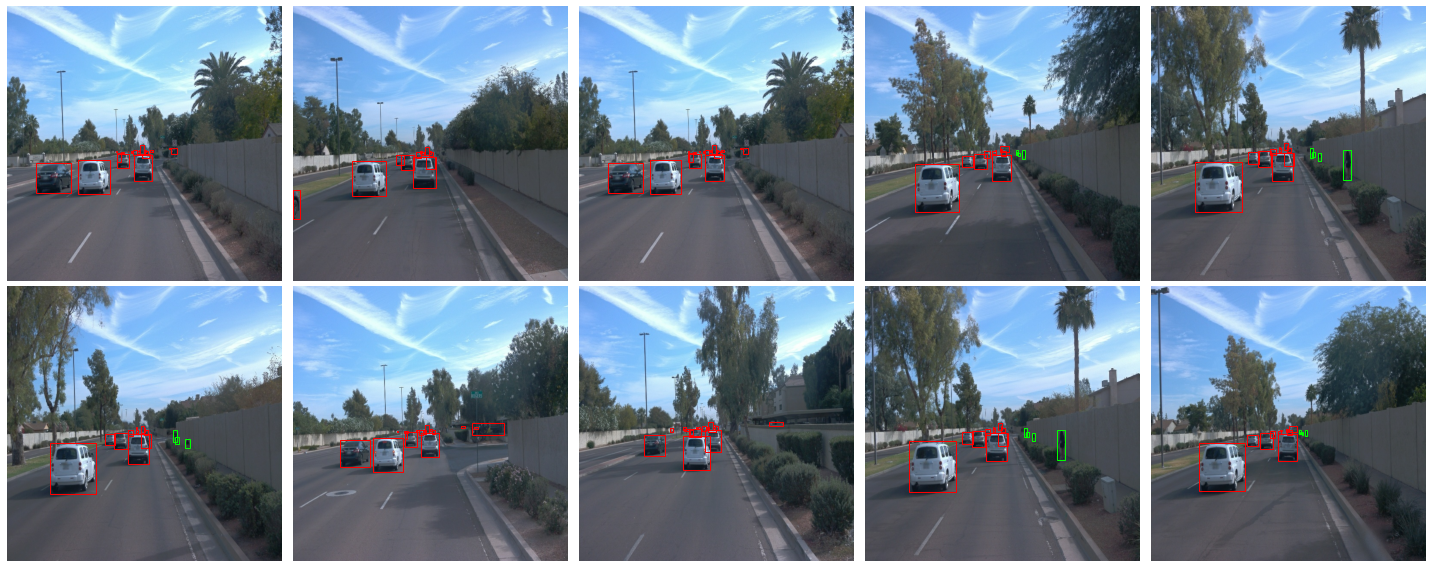

In [44]:
## STUDENT SOLUTION HERE
samples = dataset.shuffle(1).take(10)
display_instances(samples)

## Additional EDA

In this last part, you are free to perform any additional analysis of the dataset. What else would like to know about the data?
For example, think about data distribution. So far, you have only looked at a single file...

## Appearance Frequencies  

We will count the appearance frequencies of each classes in all records in "training_and_validation" folder.

In [46]:
from collections import Counter
from tqdm import tqdm_notebook

# Count the number of object classes in gt labels
tf_records_list = os.listdir("./data/waymo/training_and_validation/")
class_counter = Counter()
for tf_record in tqdm_notebook(tf_records_list):
    dataset = get_dataset(f"./data/waymo/training_and_validation/{tf_record}")
    for gt in dataset.shuffle(1).take(100).as_numpy_iterator():
        class_counter.update(gt["groundtruth_classes"])

/data/virtual_envs/sdc-c1-gpu-augment/lib/python3.7/site-packages/ipykernel_launcher.py:7: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  import sys


  0%|          | 0/97 [00:00<?, ?it/s]

INFO:tensorflow:Reading unweighted datasets: ['./data/waymo/training_and_validation/segment-1005081002024129653_5313_150_5333_150_with_camera_labels.tfrecord']
INFO:tensorflow:Reading record datasets for input file: ['./data/waymo/training_and_validation/segment-1005081002024129653_5313_150_5333_150_with_camera_labels.tfrecord']
INFO:tensorflow:Number of filenames to read: 1
INFO:tensorflow:Reading unweighted datasets: ['./data/waymo/training_and_validation/segment-10963653239323173269_1924_000_1944_000_with_camera_labels.tfrecord']
INFO:tensorflow:Reading record datasets for input file: ['./data/waymo/training_and_validation/segment-10963653239323173269_1924_000_1944_000_with_camera_labels.tfrecord']
INFO:tensorflow:Number of filenames to read: 1
INFO:tensorflow:Reading unweighted datasets: ['./data/waymo/training_and_validation/segment-11017034898130016754_697_830_717_830_with_camera_labels.tfrecord']
INFO:tensorflow:Reading record datasets for input file: ['./data/waymo/training_and

INFO:tensorflow:Reading unweighted datasets: ['./data/waymo/training_and_validation/segment-11343624116265195592_5910_530_5930_530_with_camera_labels.tfrecord']
INFO:tensorflow:Reading record datasets for input file: ['./data/waymo/training_and_validation/segment-11343624116265195592_5910_530_5930_530_with_camera_labels.tfrecord']
INFO:tensorflow:Number of filenames to read: 1
INFO:tensorflow:Reading unweighted datasets: ['./data/waymo/training_and_validation/segment-10327752107000040525_1120_000_1140_000_with_camera_labels.tfrecord']
INFO:tensorflow:Reading record datasets for input file: ['./data/waymo/training_and_validation/segment-10327752107000040525_1120_000_1140_000_with_camera_labels.tfrecord']
INFO:tensorflow:Number of filenames to read: 1
INFO:tensorflow:Reading unweighted datasets: ['./data/waymo/training_and_validation/segment-11566385337103696871_5740_000_5760_000_with_camera_labels.tfrecord']
INFO:tensorflow:Reading record datasets for input file: ['./data/waymo/training

INFO:tensorflow:Number of filenames to read: 1
INFO:tensorflow:Reading unweighted datasets: ['./data/waymo/training_and_validation/segment-10584247114982259878_490_000_510_000_with_camera_labels.tfrecord']
INFO:tensorflow:Reading record datasets for input file: ['./data/waymo/training_and_validation/segment-10584247114982259878_490_000_510_000_with_camera_labels.tfrecord']
INFO:tensorflow:Number of filenames to read: 1
INFO:tensorflow:Reading unweighted datasets: ['./data/waymo/training_and_validation/segment-10455472356147194054_1560_000_1580_000_with_camera_labels.tfrecord']
INFO:tensorflow:Reading record datasets for input file: ['./data/waymo/training_and_validation/segment-10455472356147194054_1560_000_1580_000_with_camera_labels.tfrecord']
INFO:tensorflow:Number of filenames to read: 1
INFO:tensorflow:Reading unweighted datasets: ['./data/waymo/training_and_validation/segment-11004685739714500220_2300_000_2320_000_with_camera_labels.tfrecord']
INFO:tensorflow:Reading record datas

INFO:tensorflow:Number of filenames to read: 1
INFO:tensorflow:Reading unweighted datasets: ['./data/waymo/training_and_validation/segment-1022527355599519580_4866_960_4886_960_with_camera_labels.tfrecord']
INFO:tensorflow:Reading record datasets for input file: ['./data/waymo/training_and_validation/segment-1022527355599519580_4866_960_4886_960_with_camera_labels.tfrecord']
INFO:tensorflow:Number of filenames to read: 1
INFO:tensorflow:Reading unweighted datasets: ['./data/waymo/training_and_validation/segment-11846396154240966170_3540_000_3560_000_with_camera_labels.tfrecord']
INFO:tensorflow:Reading record datasets for input file: ['./data/waymo/training_and_validation/segment-11846396154240966170_3540_000_3560_000_with_camera_labels.tfrecord']
INFO:tensorflow:Number of filenames to read: 1
INFO:tensorflow:Reading unweighted datasets: ['./data/waymo/training_and_validation/segment-11588853832866011756_2184_462_2204_462_with_camera_labels.tfrecord']
INFO:tensorflow:Reading record dat

INFO:tensorflow:Number of filenames to read: 1
INFO:tensorflow:Reading unweighted datasets: ['./data/waymo/training_and_validation/segment-10212406498497081993_5300_000_5320_000_with_camera_labels.tfrecord']
INFO:tensorflow:Reading record datasets for input file: ['./data/waymo/training_and_validation/segment-10212406498497081993_5300_000_5320_000_with_camera_labels.tfrecord']
INFO:tensorflow:Number of filenames to read: 1
INFO:tensorflow:Reading unweighted datasets: ['./data/waymo/training_and_validation/segment-10206293520369375008_2796_800_2816_800_with_camera_labels.tfrecord']
INFO:tensorflow:Reading record datasets for input file: ['./data/waymo/training_and_validation/segment-10206293520369375008_2796_800_2816_800_with_camera_labels.tfrecord']
INFO:tensorflow:Number of filenames to read: 1
INFO:tensorflow:Reading unweighted datasets: ['./data/waymo/training_and_validation/segment-10153695247769592104_787_000_807_000_with_camera_labels.tfrecord']
INFO:tensorflow:Reading record dat

INFO:tensorflow:Number of filenames to read: 1
INFO:tensorflow:Reading unweighted datasets: ['./data/waymo/training_and_validation/segment-10107710434105775874_760_000_780_000_with_camera_labels.tfrecord']
INFO:tensorflow:Reading record datasets for input file: ['./data/waymo/training_and_validation/segment-10107710434105775874_760_000_780_000_with_camera_labels.tfrecord']
INFO:tensorflow:Number of filenames to read: 1
INFO:tensorflow:Reading unweighted datasets: ['./data/waymo/training_and_validation/segment-10793018113277660068_2714_540_2734_540_with_camera_labels.tfrecord']
INFO:tensorflow:Reading record datasets for input file: ['./data/waymo/training_and_validation/segment-10793018113277660068_2714_540_2734_540_with_camera_labels.tfrecord']
INFO:tensorflow:Number of filenames to read: 1
INFO:tensorflow:Reading unweighted datasets: ['./data/waymo/training_and_validation/segment-10235335145367115211_5420_000_5440_000_with_camera_labels.tfrecord']
INFO:tensorflow:Reading record datas

In [49]:
# RESULTS
print(class_counter)

# 1: Car, 2: Pedestrian, 4: Cyclist

Counter({1: 174233, 2: 52280, 4: 1450})


In [52]:
# calculating probabilities
keys = np.array(list(class_counter.keys()))
values = np.array(list(class_counter.values()))
prob = values / values.sum()

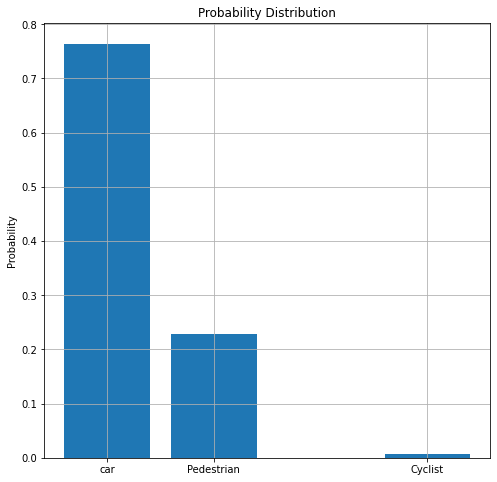

In [58]:
# Visualization
plt.figure(figsize=(8,8))
plt.bar(keys, prob)
plt.title("Probability Distribution")
plt.xticks([1, 2, 4], ["car", "Pedestrian", "Cyclist"])
plt.ylabel("Probability")
plt.grid()
plt.show()

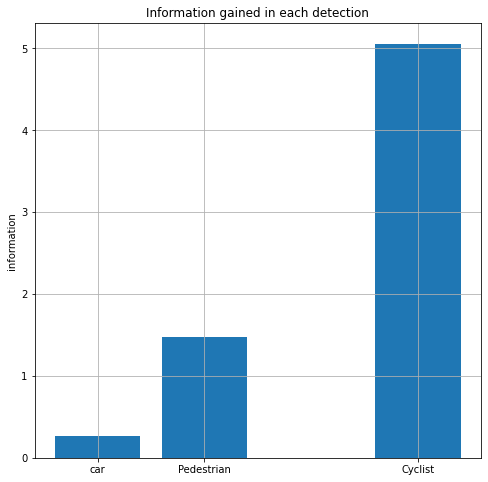

In [59]:
# information is negative log probability
information = -np.log(prob)

# Visualization
plt.figure(figsize=(8,8))
plt.bar(keys, information)
plt.title("Information gained in each detection")
plt.xticks([1, 2, 4], ["car", "Pedestrian", "Cyclist"])
plt.ylabel("information")
plt.grid()
plt.show()

## Sample images from other files

These sample images have different lightning and weather conditions. Also the frequencies of oject classes differ for each samples.

/data/virtual_envs/sdc-c1-gpu-augment/lib/python3.7/site-packages/ipykernel_launcher.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  This is separate from the ipykernel package so we can avoid doing imports until


  0%|          | 0/25 [00:00<?, ?it/s]

INFO:tensorflow:Reading unweighted datasets: ['./data/waymo/training_and_validation/segment-1005081002024129653_5313_150_5333_150_with_camera_labels.tfrecord']
INFO:tensorflow:Reading record datasets for input file: ['./data/waymo/training_and_validation/segment-1005081002024129653_5313_150_5333_150_with_camera_labels.tfrecord']
INFO:tensorflow:Number of filenames to read: 1
'AxesSubplot' object is not subscriptable
'AxesSubplot' object is not subscriptable
'AxesSubplot' object is not subscriptable
'AxesSubplot' object is not subscriptable
'AxesSubplot' object is not subscriptable
'AxesSubplot' object is not subscriptable
'AxesSubplot' object is not subscriptable
'AxesSubplot' object is not subscriptable
'AxesSubplot' object is not subscriptable
'AxesSubplot' object is not subscriptable
'AxesSubplot' object is not subscriptable
'AxesSubplot' object is not subscriptable
'AxesSubplot' object is not subscriptable
'AxesSubplot' object is not subscriptable
'AxesSubplot' object is not subscr

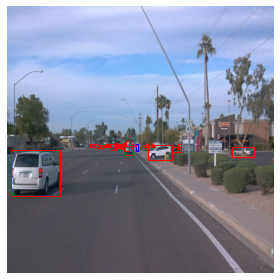

INFO:tensorflow:Reading unweighted datasets: ['./data/waymo/training_and_validation/segment-10096619443888687526_2820_000_2840_000_with_camera_labels.tfrecord']
INFO:tensorflow:Reading record datasets for input file: ['./data/waymo/training_and_validation/segment-10096619443888687526_2820_000_2840_000_with_camera_labels.tfrecord']
INFO:tensorflow:Number of filenames to read: 1
'AxesSubplot' object is not subscriptable
'AxesSubplot' object is not subscriptable
'AxesSubplot' object is not subscriptable
'AxesSubplot' object is not subscriptable
'AxesSubplot' object is not subscriptable
'AxesSubplot' object is not subscriptable
'AxesSubplot' object is not subscriptable
'AxesSubplot' object is not subscriptable
'AxesSubplot' object is not subscriptable
'AxesSubplot' object is not subscriptable
'AxesSubplot' object is not subscriptable
'AxesSubplot' object is not subscriptable
'AxesSubplot' object is not subscriptable
'AxesSubplot' object is not subscriptable
'AxesSubplot' object is not subs

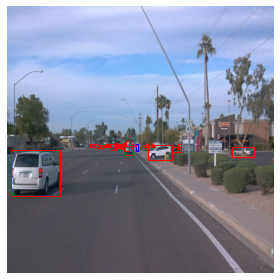

INFO:tensorflow:Reading unweighted datasets: ['./data/waymo/training_and_validation/segment-11199484219241918646_2810_030_2830_030_with_camera_labels.tfrecord']
INFO:tensorflow:Reading record datasets for input file: ['./data/waymo/training_and_validation/segment-11199484219241918646_2810_030_2830_030_with_camera_labels.tfrecord']
INFO:tensorflow:Number of filenames to read: 1
'AxesSubplot' object is not subscriptable
'AxesSubplot' object is not subscriptable
'AxesSubplot' object is not subscriptable
'AxesSubplot' object is not subscriptable
'AxesSubplot' object is not subscriptable
'AxesSubplot' object is not subscriptable
'AxesSubplot' object is not subscriptable
'AxesSubplot' object is not subscriptable
'AxesSubplot' object is not subscriptable
'AxesSubplot' object is not subscriptable
'AxesSubplot' object is not subscriptable
'AxesSubplot' object is not subscriptable
'AxesSubplot' object is not subscriptable
'AxesSubplot' object is not subscriptable
'AxesSubplot' object is not subs

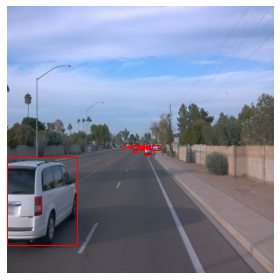

INFO:tensorflow:Reading unweighted datasets: ['./data/waymo/training_and_validation/segment-10964956617027590844_1584_680_1604_680_with_camera_labels.tfrecord']
INFO:tensorflow:Reading record datasets for input file: ['./data/waymo/training_and_validation/segment-10964956617027590844_1584_680_1604_680_with_camera_labels.tfrecord']
INFO:tensorflow:Number of filenames to read: 1
'AxesSubplot' object is not subscriptable
'AxesSubplot' object is not subscriptable
'AxesSubplot' object is not subscriptable
'AxesSubplot' object is not subscriptable
'AxesSubplot' object is not subscriptable
'AxesSubplot' object is not subscriptable
'AxesSubplot' object is not subscriptable
'AxesSubplot' object is not subscriptable
'AxesSubplot' object is not subscriptable
'AxesSubplot' object is not subscriptable
'AxesSubplot' object is not subscriptable
'AxesSubplot' object is not subscriptable
'AxesSubplot' object is not subscriptable
'AxesSubplot' object is not subscriptable
'AxesSubplot' object is not subs

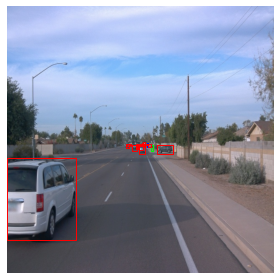

INFO:tensorflow:Reading unweighted datasets: ['./data/waymo/training_and_validation/segment-1191788760630624072_3880_000_3900_000_with_camera_labels.tfrecord']
INFO:tensorflow:Reading record datasets for input file: ['./data/waymo/training_and_validation/segment-1191788760630624072_3880_000_3900_000_with_camera_labels.tfrecord']
INFO:tensorflow:Number of filenames to read: 1
'AxesSubplot' object is not subscriptable
'AxesSubplot' object is not subscriptable
'AxesSubplot' object is not subscriptable
'AxesSubplot' object is not subscriptable
'AxesSubplot' object is not subscriptable
'AxesSubplot' object is not subscriptable
'AxesSubplot' object is not subscriptable
'AxesSubplot' object is not subscriptable
'AxesSubplot' object is not subscriptable
'AxesSubplot' object is not subscriptable
'AxesSubplot' object is not subscriptable
'AxesSubplot' object is not subscriptable
'AxesSubplot' object is not subscriptable
'AxesSubplot' object is not subscriptable
'AxesSubplot' object is not subscr

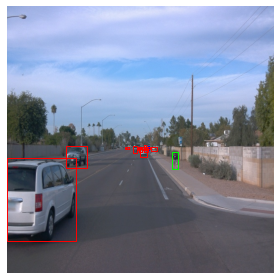

INFO:tensorflow:Reading unweighted datasets: ['./data/waymo/training_and_validation/segment-11566385337103696871_5740_000_5760_000_with_camera_labels.tfrecord']
INFO:tensorflow:Reading record datasets for input file: ['./data/waymo/training_and_validation/segment-11566385337103696871_5740_000_5760_000_with_camera_labels.tfrecord']
INFO:tensorflow:Number of filenames to read: 1
'AxesSubplot' object is not subscriptable
'AxesSubplot' object is not subscriptable
'AxesSubplot' object is not subscriptable
'AxesSubplot' object is not subscriptable
'AxesSubplot' object is not subscriptable
'AxesSubplot' object is not subscriptable
'AxesSubplot' object is not subscriptable
'AxesSubplot' object is not subscriptable
'AxesSubplot' object is not subscriptable
'AxesSubplot' object is not subscriptable
'AxesSubplot' object is not subscriptable
'AxesSubplot' object is not subscriptable
'AxesSubplot' object is not subscriptable
'AxesSubplot' object is not subscriptable
'AxesSubplot' object is not subs

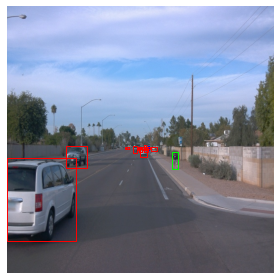

INFO:tensorflow:Reading unweighted datasets: ['./data/waymo/training_and_validation/segment-12161824480686739258_1813_380_1833_380_with_camera_labels.tfrecord']
INFO:tensorflow:Reading record datasets for input file: ['./data/waymo/training_and_validation/segment-12161824480686739258_1813_380_1833_380_with_camera_labels.tfrecord']
INFO:tensorflow:Number of filenames to read: 1
'AxesSubplot' object is not subscriptable
'AxesSubplot' object is not subscriptable
'AxesSubplot' object is not subscriptable
'AxesSubplot' object is not subscriptable
'AxesSubplot' object is not subscriptable
'AxesSubplot' object is not subscriptable
'AxesSubplot' object is not subscriptable
'AxesSubplot' object is not subscriptable
'AxesSubplot' object is not subscriptable
'AxesSubplot' object is not subscriptable
'AxesSubplot' object is not subscriptable
'AxesSubplot' object is not subscriptable
'AxesSubplot' object is not subscriptable
'AxesSubplot' object is not subscriptable
'AxesSubplot' object is not subs

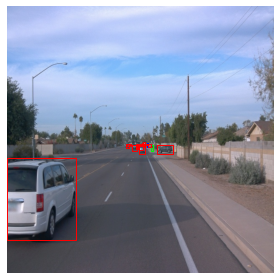

INFO:tensorflow:Reading unweighted datasets: ['./data/waymo/training_and_validation/segment-10625026498155904401_200_000_220_000_with_camera_labels.tfrecord']
INFO:tensorflow:Reading record datasets for input file: ['./data/waymo/training_and_validation/segment-10625026498155904401_200_000_220_000_with_camera_labels.tfrecord']
INFO:tensorflow:Number of filenames to read: 1
'AxesSubplot' object is not subscriptable
'AxesSubplot' object is not subscriptable
'AxesSubplot' object is not subscriptable
'AxesSubplot' object is not subscriptable
'AxesSubplot' object is not subscriptable
'AxesSubplot' object is not subscriptable
'AxesSubplot' object is not subscriptable
'AxesSubplot' object is not subscriptable
'AxesSubplot' object is not subscriptable
'AxesSubplot' object is not subscriptable
'AxesSubplot' object is not subscriptable
'AxesSubplot' object is not subscriptable
'AxesSubplot' object is not subscriptable
'AxesSubplot' object is not subscriptable
'AxesSubplot' object is not subscrip

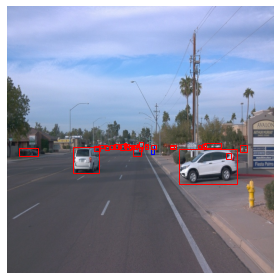

INFO:tensorflow:Reading unweighted datasets: ['./data/waymo/training_and_validation/segment-10599748131695282446_1380_000_1400_000_with_camera_labels.tfrecord']
INFO:tensorflow:Reading record datasets for input file: ['./data/waymo/training_and_validation/segment-10599748131695282446_1380_000_1400_000_with_camera_labels.tfrecord']
INFO:tensorflow:Number of filenames to read: 1
'AxesSubplot' object is not subscriptable
'AxesSubplot' object is not subscriptable
'AxesSubplot' object is not subscriptable
'AxesSubplot' object is not subscriptable
'AxesSubplot' object is not subscriptable
'AxesSubplot' object is not subscriptable
'AxesSubplot' object is not subscriptable
'AxesSubplot' object is not subscriptable
'AxesSubplot' object is not subscriptable
'AxesSubplot' object is not subscriptable
'AxesSubplot' object is not subscriptable
'AxesSubplot' object is not subscriptable
'AxesSubplot' object is not subscriptable
'AxesSubplot' object is not subscriptable
'AxesSubplot' object is not subs

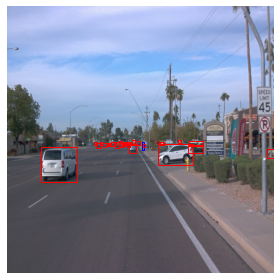

INFO:tensorflow:Reading unweighted datasets: ['./data/waymo/training_and_validation/segment-10584247114982259878_490_000_510_000_with_camera_labels.tfrecord']
INFO:tensorflow:Reading record datasets for input file: ['./data/waymo/training_and_validation/segment-10584247114982259878_490_000_510_000_with_camera_labels.tfrecord']
INFO:tensorflow:Number of filenames to read: 1
'AxesSubplot' object is not subscriptable
'AxesSubplot' object is not subscriptable
'AxesSubplot' object is not subscriptable
'AxesSubplot' object is not subscriptable
'AxesSubplot' object is not subscriptable
'AxesSubplot' object is not subscriptable
'AxesSubplot' object is not subscriptable
'AxesSubplot' object is not subscriptable
'AxesSubplot' object is not subscriptable
'AxesSubplot' object is not subscriptable
'AxesSubplot' object is not subscriptable
'AxesSubplot' object is not subscriptable
'AxesSubplot' object is not subscriptable
'AxesSubplot' object is not subscriptable
'AxesSubplot' object is not subscrip

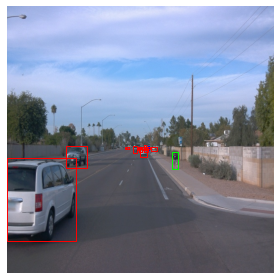

INFO:tensorflow:Reading unweighted datasets: ['./data/waymo/training_and_validation/segment-11489533038039664633_4820_000_4840_000_with_camera_labels.tfrecord']
INFO:tensorflow:Reading record datasets for input file: ['./data/waymo/training_and_validation/segment-11489533038039664633_4820_000_4840_000_with_camera_labels.tfrecord']
INFO:tensorflow:Number of filenames to read: 1
'AxesSubplot' object is not subscriptable
'AxesSubplot' object is not subscriptable
'AxesSubplot' object is not subscriptable
'AxesSubplot' object is not subscriptable
'AxesSubplot' object is not subscriptable
'AxesSubplot' object is not subscriptable
'AxesSubplot' object is not subscriptable
'AxesSubplot' object is not subscriptable
'AxesSubplot' object is not subscriptable
'AxesSubplot' object is not subscriptable
'AxesSubplot' object is not subscriptable
'AxesSubplot' object is not subscriptable
'AxesSubplot' object is not subscriptable
'AxesSubplot' object is not subscriptable
'AxesSubplot' object is not subs

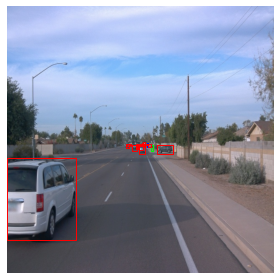

INFO:tensorflow:Reading unweighted datasets: ['./data/waymo/training_and_validation/segment-10094743350625019937_3420_000_3440_000_with_camera_labels.tfrecord']
INFO:tensorflow:Reading record datasets for input file: ['./data/waymo/training_and_validation/segment-10094743350625019937_3420_000_3440_000_with_camera_labels.tfrecord']
INFO:tensorflow:Number of filenames to read: 1
'AxesSubplot' object is not subscriptable
'AxesSubplot' object is not subscriptable
'AxesSubplot' object is not subscriptable
'AxesSubplot' object is not subscriptable
'AxesSubplot' object is not subscriptable
'AxesSubplot' object is not subscriptable
'AxesSubplot' object is not subscriptable
'AxesSubplot' object is not subscriptable
'AxesSubplot' object is not subscriptable
'AxesSubplot' object is not subscriptable
'AxesSubplot' object is not subscriptable
'AxesSubplot' object is not subscriptable
'AxesSubplot' object is not subscriptable
'AxesSubplot' object is not subscriptable
'AxesSubplot' object is not subs

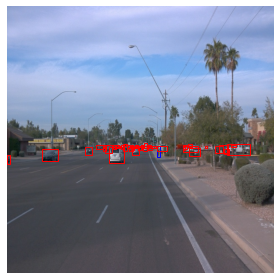

INFO:tensorflow:Reading unweighted datasets: ['./data/waymo/training_and_validation/segment-11126313430116606120_1439_990_1459_990_with_camera_labels.tfrecord']
INFO:tensorflow:Reading record datasets for input file: ['./data/waymo/training_and_validation/segment-11126313430116606120_1439_990_1459_990_with_camera_labels.tfrecord']
INFO:tensorflow:Number of filenames to read: 1
'AxesSubplot' object is not subscriptable
'AxesSubplot' object is not subscriptable
'AxesSubplot' object is not subscriptable
'AxesSubplot' object is not subscriptable
'AxesSubplot' object is not subscriptable
'AxesSubplot' object is not subscriptable
'AxesSubplot' object is not subscriptable
'AxesSubplot' object is not subscriptable
'AxesSubplot' object is not subscriptable
'AxesSubplot' object is not subscriptable
'AxesSubplot' object is not subscriptable
'AxesSubplot' object is not subscriptable
'AxesSubplot' object is not subscriptable
'AxesSubplot' object is not subscriptable
'AxesSubplot' object is not subs

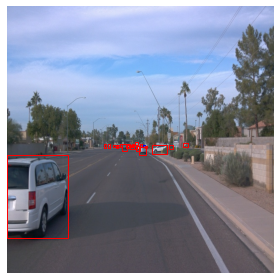

INFO:tensorflow:Reading unweighted datasets: ['./data/waymo/training_and_validation/segment-10275144660749673822_5755_561_5775_561_with_camera_labels.tfrecord']
INFO:tensorflow:Reading record datasets for input file: ['./data/waymo/training_and_validation/segment-10275144660749673822_5755_561_5775_561_with_camera_labels.tfrecord']
INFO:tensorflow:Number of filenames to read: 1
'AxesSubplot' object is not subscriptable
'AxesSubplot' object is not subscriptable
'AxesSubplot' object is not subscriptable
'AxesSubplot' object is not subscriptable
'AxesSubplot' object is not subscriptable
'AxesSubplot' object is not subscriptable
'AxesSubplot' object is not subscriptable
'AxesSubplot' object is not subscriptable
'AxesSubplot' object is not subscriptable
'AxesSubplot' object is not subscriptable
'AxesSubplot' object is not subscriptable
'AxesSubplot' object is not subscriptable
'AxesSubplot' object is not subscriptable
'AxesSubplot' object is not subscriptable
'AxesSubplot' object is not subs

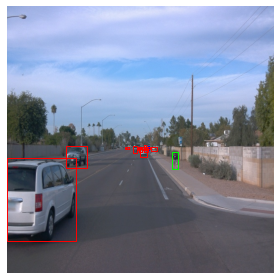

INFO:tensorflow:Reading unweighted datasets: ['./data/waymo/training_and_validation/segment-11588853832866011756_2184_462_2204_462_with_camera_labels.tfrecord']
INFO:tensorflow:Reading record datasets for input file: ['./data/waymo/training_and_validation/segment-11588853832866011756_2184_462_2204_462_with_camera_labels.tfrecord']
INFO:tensorflow:Number of filenames to read: 1
'AxesSubplot' object is not subscriptable
'AxesSubplot' object is not subscriptable
'AxesSubplot' object is not subscriptable
'AxesSubplot' object is not subscriptable
'AxesSubplot' object is not subscriptable
'AxesSubplot' object is not subscriptable
'AxesSubplot' object is not subscriptable
'AxesSubplot' object is not subscriptable
'AxesSubplot' object is not subscriptable
'AxesSubplot' object is not subscriptable
'AxesSubplot' object is not subscriptable
'AxesSubplot' object is not subscriptable
'AxesSubplot' object is not subscriptable
'AxesSubplot' object is not subscriptable
'AxesSubplot' object is not subs

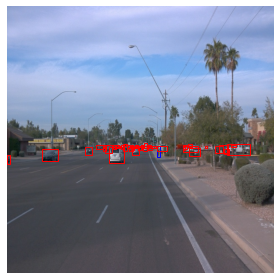

INFO:tensorflow:Reading unweighted datasets: ['./data/waymo/training_and_validation/segment-12174529769287588121_3848_440_3868_440_with_camera_labels.tfrecord']
INFO:tensorflow:Reading record datasets for input file: ['./data/waymo/training_and_validation/segment-12174529769287588121_3848_440_3868_440_with_camera_labels.tfrecord']
INFO:tensorflow:Number of filenames to read: 1
'AxesSubplot' object is not subscriptable
'AxesSubplot' object is not subscriptable
'AxesSubplot' object is not subscriptable
'AxesSubplot' object is not subscriptable
'AxesSubplot' object is not subscriptable
'AxesSubplot' object is not subscriptable
'AxesSubplot' object is not subscriptable
'AxesSubplot' object is not subscriptable
'AxesSubplot' object is not subscriptable
'AxesSubplot' object is not subscriptable
'AxesSubplot' object is not subscriptable
'AxesSubplot' object is not subscriptable
'AxesSubplot' object is not subscriptable
'AxesSubplot' object is not subscriptable
'AxesSubplot' object is not subs

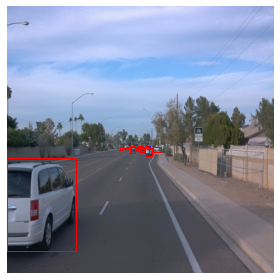

INFO:tensorflow:Reading unweighted datasets: ['./data/waymo/training_and_validation/segment-11967272535264406807_580_000_600_000_with_camera_labels.tfrecord']
INFO:tensorflow:Reading record datasets for input file: ['./data/waymo/training_and_validation/segment-11967272535264406807_580_000_600_000_with_camera_labels.tfrecord']
INFO:tensorflow:Number of filenames to read: 1
'AxesSubplot' object is not subscriptable
'AxesSubplot' object is not subscriptable
'AxesSubplot' object is not subscriptable
'AxesSubplot' object is not subscriptable
'AxesSubplot' object is not subscriptable
'AxesSubplot' object is not subscriptable
'AxesSubplot' object is not subscriptable
'AxesSubplot' object is not subscriptable
'AxesSubplot' object is not subscriptable
'AxesSubplot' object is not subscriptable
'AxesSubplot' object is not subscriptable
'AxesSubplot' object is not subscriptable
'AxesSubplot' object is not subscriptable
'AxesSubplot' object is not subscriptable
'AxesSubplot' object is not subscrip

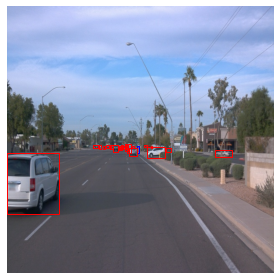

INFO:tensorflow:Reading unweighted datasets: ['./data/waymo/training_and_validation/segment-11252086830380107152_1540_000_1560_000_with_camera_labels.tfrecord']
INFO:tensorflow:Reading record datasets for input file: ['./data/waymo/training_and_validation/segment-11252086830380107152_1540_000_1560_000_with_camera_labels.tfrecord']
INFO:tensorflow:Number of filenames to read: 1
'AxesSubplot' object is not subscriptable
'AxesSubplot' object is not subscriptable
'AxesSubplot' object is not subscriptable
'AxesSubplot' object is not subscriptable
'AxesSubplot' object is not subscriptable
'AxesSubplot' object is not subscriptable
'AxesSubplot' object is not subscriptable
'AxesSubplot' object is not subscriptable
'AxesSubplot' object is not subscriptable
'AxesSubplot' object is not subscriptable
'AxesSubplot' object is not subscriptable
'AxesSubplot' object is not subscriptable
'AxesSubplot' object is not subscriptable
'AxesSubplot' object is not subscriptable
'AxesSubplot' object is not subs

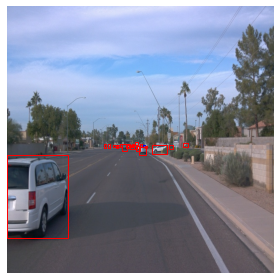

INFO:tensorflow:Reading unweighted datasets: ['./data/waymo/training_and_validation/segment-10212406498497081993_5300_000_5320_000_with_camera_labels.tfrecord']
INFO:tensorflow:Reading record datasets for input file: ['./data/waymo/training_and_validation/segment-10212406498497081993_5300_000_5320_000_with_camera_labels.tfrecord']
INFO:tensorflow:Number of filenames to read: 1
'AxesSubplot' object is not subscriptable
'AxesSubplot' object is not subscriptable
'AxesSubplot' object is not subscriptable
'AxesSubplot' object is not subscriptable
'AxesSubplot' object is not subscriptable
'AxesSubplot' object is not subscriptable
'AxesSubplot' object is not subscriptable
'AxesSubplot' object is not subscriptable
'AxesSubplot' object is not subscriptable
'AxesSubplot' object is not subscriptable
'AxesSubplot' object is not subscriptable
'AxesSubplot' object is not subscriptable
'AxesSubplot' object is not subscriptable
'AxesSubplot' object is not subscriptable
'AxesSubplot' object is not subs

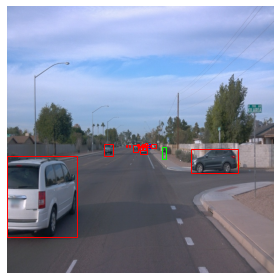

INFO:tensorflow:Reading unweighted datasets: ['./data/waymo/training_and_validation/segment-10724020115992582208_7660_400_7680_400_with_camera_labels.tfrecord']
INFO:tensorflow:Reading record datasets for input file: ['./data/waymo/training_and_validation/segment-10724020115992582208_7660_400_7680_400_with_camera_labels.tfrecord']
INFO:tensorflow:Number of filenames to read: 1
'AxesSubplot' object is not subscriptable
'AxesSubplot' object is not subscriptable
'AxesSubplot' object is not subscriptable
'AxesSubplot' object is not subscriptable
'AxesSubplot' object is not subscriptable
'AxesSubplot' object is not subscriptable
'AxesSubplot' object is not subscriptable
'AxesSubplot' object is not subscriptable
'AxesSubplot' object is not subscriptable
'AxesSubplot' object is not subscriptable
'AxesSubplot' object is not subscriptable
'AxesSubplot' object is not subscriptable
'AxesSubplot' object is not subscriptable
'AxesSubplot' object is not subscriptable
'AxesSubplot' object is not subs

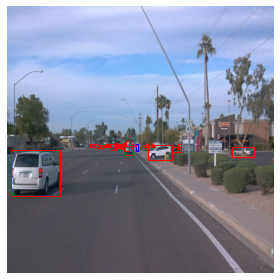

INFO:tensorflow:Reading unweighted datasets: ['./data/waymo/training_and_validation/segment-10023947602400723454_1120_000_1140_000_with_camera_labels.tfrecord']
INFO:tensorflow:Reading record datasets for input file: ['./data/waymo/training_and_validation/segment-10023947602400723454_1120_000_1140_000_with_camera_labels.tfrecord']
INFO:tensorflow:Number of filenames to read: 1
'AxesSubplot' object is not subscriptable
'AxesSubplot' object is not subscriptable
'AxesSubplot' object is not subscriptable
'AxesSubplot' object is not subscriptable
'AxesSubplot' object is not subscriptable
'AxesSubplot' object is not subscriptable
'AxesSubplot' object is not subscriptable
'AxesSubplot' object is not subscriptable
'AxesSubplot' object is not subscriptable
'AxesSubplot' object is not subscriptable
'AxesSubplot' object is not subscriptable
'AxesSubplot' object is not subscriptable
'AxesSubplot' object is not subscriptable
'AxesSubplot' object is not subscriptable
'AxesSubplot' object is not subs

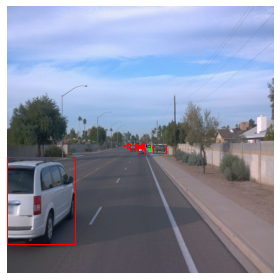

INFO:tensorflow:Reading unweighted datasets: ['./data/waymo/training_and_validation/segment-10485926982439064520_4980_000_5000_000_with_camera_labels.tfrecord']
INFO:tensorflow:Reading record datasets for input file: ['./data/waymo/training_and_validation/segment-10485926982439064520_4980_000_5000_000_with_camera_labels.tfrecord']
INFO:tensorflow:Number of filenames to read: 1
'AxesSubplot' object is not subscriptable
'AxesSubplot' object is not subscriptable
'AxesSubplot' object is not subscriptable
'AxesSubplot' object is not subscriptable
'AxesSubplot' object is not subscriptable
'AxesSubplot' object is not subscriptable
'AxesSubplot' object is not subscriptable
'AxesSubplot' object is not subscriptable
'AxesSubplot' object is not subscriptable
'AxesSubplot' object is not subscriptable
'AxesSubplot' object is not subscriptable
'AxesSubplot' object is not subscriptable
'AxesSubplot' object is not subscriptable
'AxesSubplot' object is not subscriptable
'AxesSubplot' object is not subs

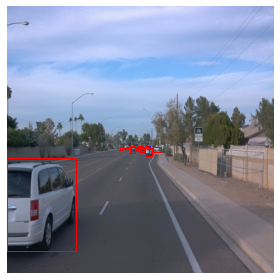

INFO:tensorflow:Reading unweighted datasets: ['./data/waymo/training_and_validation/segment-11839652018869852123_2565_000_2585_000_with_camera_labels.tfrecord']
INFO:tensorflow:Reading record datasets for input file: ['./data/waymo/training_and_validation/segment-11839652018869852123_2565_000_2585_000_with_camera_labels.tfrecord']
INFO:tensorflow:Number of filenames to read: 1
'AxesSubplot' object is not subscriptable
'AxesSubplot' object is not subscriptable
'AxesSubplot' object is not subscriptable
'AxesSubplot' object is not subscriptable
'AxesSubplot' object is not subscriptable
'AxesSubplot' object is not subscriptable
'AxesSubplot' object is not subscriptable
'AxesSubplot' object is not subscriptable
'AxesSubplot' object is not subscriptable
'AxesSubplot' object is not subscriptable
'AxesSubplot' object is not subscriptable
'AxesSubplot' object is not subscriptable
'AxesSubplot' object is not subscriptable
'AxesSubplot' object is not subscriptable
'AxesSubplot' object is not subs

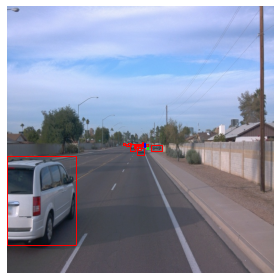

INFO:tensorflow:Reading unweighted datasets: ['./data/waymo/training_and_validation/segment-10235335145367115211_5420_000_5440_000_with_camera_labels.tfrecord']
INFO:tensorflow:Reading record datasets for input file: ['./data/waymo/training_and_validation/segment-10235335145367115211_5420_000_5440_000_with_camera_labels.tfrecord']
INFO:tensorflow:Number of filenames to read: 1
'AxesSubplot' object is not subscriptable
'AxesSubplot' object is not subscriptable
'AxesSubplot' object is not subscriptable
'AxesSubplot' object is not subscriptable
'AxesSubplot' object is not subscriptable
'AxesSubplot' object is not subscriptable
'AxesSubplot' object is not subscriptable
'AxesSubplot' object is not subscriptable
'AxesSubplot' object is not subscriptable
'AxesSubplot' object is not subscriptable
'AxesSubplot' object is not subscriptable
'AxesSubplot' object is not subscriptable
'AxesSubplot' object is not subscriptable
'AxesSubplot' object is not subscriptable
'AxesSubplot' object is not subs

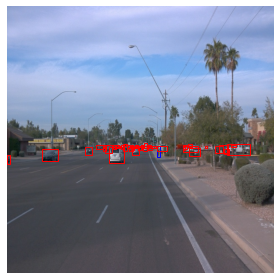

INFO:tensorflow:Reading unweighted datasets: ['./data/waymo/training_and_validation/segment-12027892938363296829_4086_280_4106_280_with_camera_labels.tfrecord']
INFO:tensorflow:Reading record datasets for input file: ['./data/waymo/training_and_validation/segment-12027892938363296829_4086_280_4106_280_with_camera_labels.tfrecord']
INFO:tensorflow:Number of filenames to read: 1
'AxesSubplot' object is not subscriptable
'AxesSubplot' object is not subscriptable
'AxesSubplot' object is not subscriptable
'AxesSubplot' object is not subscriptable
'AxesSubplot' object is not subscriptable
'AxesSubplot' object is not subscriptable
'AxesSubplot' object is not subscriptable
'AxesSubplot' object is not subscriptable
'AxesSubplot' object is not subscriptable
'AxesSubplot' object is not subscriptable
'AxesSubplot' object is not subscriptable
'AxesSubplot' object is not subscriptable
'AxesSubplot' object is not subscriptable
'AxesSubplot' object is not subscriptable
'AxesSubplot' object is not subs

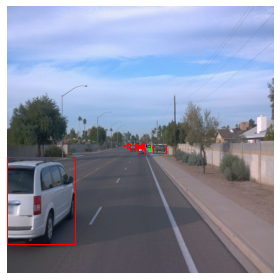

In [64]:
tf_records = os.listdir("./data/waymo/training_and_validation/")

for tf_record in tqdm_notebook(tf_records[::4]):
    dataset = get_dataset(f"./data/waymo/training_and_validation/{tf_record}")
    sample = dataset.shuffle(1).take(1)
    display_instances(samples, rows=1, cols=1)